In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import numpy as np
import json

In [6]:
import platform
import time
import pathlib
import os

In [7]:
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.10.10
Tensorflow version: 2.12.0
Keras version: 2.12.0


In [8]:
CACHE_DIR = './tmp'
pathlib.Path(CACHE_DIR).mkdir(exist_ok=True)

In [9]:
def load_dataset(silent=False):
    # List of dataset files we want to merge.
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'{CACHE_DIR}/datasets/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            # This code block outputs the summary for each dataset.
            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')

    return dataset  

dataset_raw = load_dataset() 

./tmp/datasets/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless, boneless chicke

In [10]:
print('Total number of raw examples: ', len(dataset_raw))

Total number of raw examples:  125164


In [11]:
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [12]:
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of incomplete recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 125164
Dataset size AFTER validation 122938
Number of incomplete recipes 2226


In [13]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

In [14]:
def recipe_to_string(recipe):
    # This string is presented as a part of recipes so we need to clean it up.
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [15]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  122938


In [16]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Slow Cooker Chicken and Dumplings

🥕

• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

📝

▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.



Recipe #2
---------
📗 Awesome Slow Cooker Pot Roast

🥕

• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast 

📝

▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting for 8 to 9 hours.



Recipe 

In [17]:
print(dataset_stringified[50000])

📗 Herbed Bean Ragoût 

🥕

• 6 ounces haricots verts (French thin green beans), trimmed and halved crosswise
• 1 (1-pound) bag frozen edamame (soybeans in the pod) or 1 1/4 cups frozen shelled edamame, not thawed
• 2/3 cup finely chopped onion
• 2 garlic cloves, minced
• 1 Turkish bay leaf or 1/2 California bay leaf
• 2 (3-inch) fresh rosemary sprigs
• 1/2 teaspoon salt
• 1/4 teaspoon black pepper
• 1 tablespoon olive oil
• 1 medium carrot, cut into 1/8-inch dice
• 1 medium celery rib, cut into 1/8-inch dice
• 1 (15- to 16-ounces) can small white beans, rinsed and drained
• 1 1/2 cups chicken stock or low-sodium broth
• 2 tablespoons unsalted butter
• 2 tablespoons finely chopped fresh flat-leaf parsley
• 1 tablespoon finely chopped fresh chervil (optional)
• Garnish: fresh chervil sprigs

📝

▪︎ Cook haricots verts in a large pot of boiling salted water until just tender, 3 to 4 minutes. Transfer with a slotted spoon to a bowl of ice and cold water, then drain. Add edamame to boiling wa

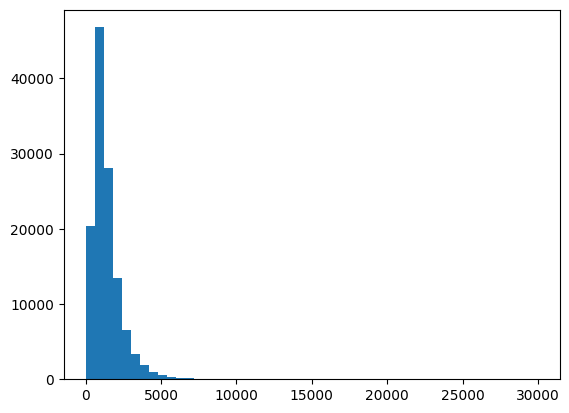

In [18]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

plt.hist(recipes_lengths, bins=50)
plt.show()

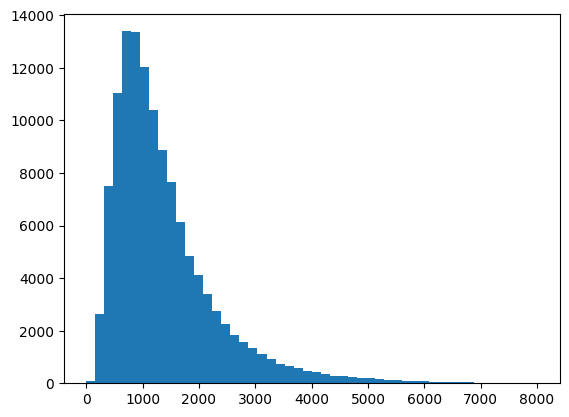

In [19]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [20]:
MAX_RECIPE_LENGTH = 2000

In [21]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of eliminated recipes: ', len(dataset_stringified) - len(dataset_filtered)) 

Dataset size BEFORE filtering:  122938
Dataset size AFTER filtering:  100212
Number of eliminated recipes:  22726


In [22]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  2000
TOTAL_RECIPES_NUM:  100212


In [23]:
STOP_SIGN = '␣'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

tokenizer.fit_on_texts(dataset_filtered)

tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 100213,
 'word_counts': '{"\\u2423": 1, "\\ud83d\\udcd7": 100212, " ": 17527888, "S": 270259, "l": 3815150, "o": 5987496, "w": 964459, "C": 222831, "k": 890982, "e": 9296022, "r": 4760887, "h": 2922100, "i": 4911812, "c": 2883507, "n": 5304396, "a": 6067157, "d": 3099679, "D": 63999, "u": 2717050, "m": 1794411, "p": 2679164, "g": 1698670, "s": 4704222, "\\n": 1955281, "\\ud83e\\udd55": 100212, "\\u2022": 922813, "4": 232607, ",": 1130487, "b": 1394803, "t": 5997722, "v": 746785, "2": 493933, "(": 144985, "1": 853931, "0": 145119, ".": 1052548, "7": 31098, "5": 154071, ")": 144977, "f": 1042981, "y": 666553, "\\ud83d\\udcdd": 100212, "\\u25aa": 331058, "\\ufe0e": 331058, "P": 200597, "6": 51398, "H": 43936, "A": 134274, "3": 213519, "R": 101253, "x": 201286, "/": 345257, "I": 81591, "L": 46138, "8": 55352, "9": 17697, "B": 123813, "M": 78684, "F": 104359, "j": 1

In [24]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  176


In [25]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[20])

o
,


In [26]:
tokenizer.word_index['r']

8

In [27]:
array_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
print([char for char in array_vocabulary])

['', ' ', 'e', 'a', 't', 'o', 'n', 'i', 'r', 's', 'l', 'd', 'h', 'c', 'u', 'p', '\n', 'm', 'g', 'b', ',', '.', 'f', 'w', '•', 'k', '1', 'v', 'y', '2', '/', '▪', '︎', 'S', '4', 'C', '-', '3', 'x', 'P', '5', '0', '(', ')', 'A', 'B', 'z', 'j', 'F', 'T', 'R', '📗', '🥕', '📝', 'I', 'M', ';', 'q', 'D', 'W', '8', 'G', '6', 'L', 'H', ':', '7', 'O', "'", 'E', 'K', '9', 'U', 'N', 'V', 'J', '®', '°', 'é', '"', 'Y', 'Q', '*', '!', 'Z', '–', '&', '%', 'ñ', 'è', '™', 'î', 'X', '?', '¿', '—', 'ç', '#', '½', 'í', '=', '’', 'â', '©', '¼', '+', '>', '$', '<', 'á', 'ó', 'ú', 'ï', 'É', 'û', ']', '[', 'ü', 'ê', 'à', '_', '\xad', '¾', '‚', '�', 'º', '⁄', 'ä', 'Ú', 'ù', '́', '}', 'ö', '{', 'ì', 'ô', '\x96', '”', '×', '˚', '»', '@', '§', '\\', '◊', '‱', '“', '‧', '\u202d', '⅛', 'å', 'ﬂ', '`', 'Á', 'ë', '\x97', '\x1a', 'ø', '⅓', '|', 'ư', '\x92', '´', '‒', 'Â', '␣', '¤', '‟', '\xa0', 'ơ', 'ă', '̀', '⅞', '€', '~', '\x95']


In [28]:
tokenizer.texts_to_sequences(['📗 yes'])

[[51, 1, 28, 2, 9]]

In [29]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

print('Vectorized dataset size', len(dataset_vectorized)) 

Vectorized dataset size 100212


In [30]:
print(dataset_vectorized[0][:10], '...') 

[51, 1, 33, 10, 5, 23, 1, 35, 5, 5] ...


In [31]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    print(recipe_stringified)

recipe_sequence_to_string(dataset_vectorized[0])

📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s 
 
 🥕 
 
 •   4   s k i n l e s s ,   b o n e l e s s   c h i c k e n   b r e a s t   h a l v e s   
 •   2   t a b l e s p o o n s   b u t t e r   
 •   2   ( 1 0 . 7 5   o u n c e )   c a n s   c o n d e n s e d   c r e a m   o f   c h i c k e n   s o u p   
 •   1   o n i o n ,   f i n e l y   d i c e d   
 •   2   ( 1 0   o u n c e )   p a c k a g e s   r e f r i g e r a t e d   b i s c u i t   d o u g h ,   t o r n   i n t o   p i e c e s   
 
 📝 
 
 ▪ ︎   P l a c e   t h e   c h i c k e n ,   b u t t e r ,   s o u p ,   a n d   o n i o n   i n   a   s l o w   c o o k e r ,   a n d   f i l l   w i t h   e n o u g h   w a t e r   t o   c o v e r . 
 ▪ ︎   C o v e r ,   a n d   c o o k   f o r   5   t o   6   h o u r s   o n   H i g h .   A b o u t   3 0   m i n u t e s   b e f o r e   s e r v i n g ,   p l a c e   t h e   t o r n   b i s c u i t   d o u g h   i n   t h e   s l o w   c o o k e r .   C o o k   u n 

In [32]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 546
Recipe #2 length: 401
Recipe #3 length: 671
Recipe #4 length: 736
Recipe #5 length: 1518
Recipe #6 length: 740
Recipe #7 length: 839
Recipe #8 length: 667
Recipe #9 length: 1264
Recipe #10 length: 854


In [33]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all recipes will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [34]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s 
 
 🥕 
 
 •   4   s k i n l e s s ,   b o n e l e s s   c h i c k e n   b r e a s t   h a l v e s   
 •   2   t a b l e s p o o n s   b u t t e r   
 •   2   ( 1 0 . 7 5   o u n c e )   c a n s   c o n d e n s e d   c r e a m   o f   c h i c k e n   s o u p   
 •   1   o n i o n ,   f i n e l y   d i c e d   
 •   2   ( 1 0   o u n c e )   p a c k a g e s   r e f r i g e r a t e d   b i s c u i t   d o u g h ,   t o r n   i n t o   p i e c e s   
 
 📝 
 
 ▪ ︎   P l a c e   t h e   c h i c k e n ,   b u t t e r ,   s o u p ,   a n d   o n i o n   i n   a   s l o w   c o o k e r ,   a n d   f i l l   w i t h   e n o u g h   w a t e r   t o   c o v e r . 
 ▪ ︎   C o v e r ,   a n d   c o o k   f o r   5   t o   6   h o u r s   o n   H i g h .   A b o u t   3 0   m i n u t e s   b e f o r e   s e r v i n g ,   p l a c e   t h e   t o r n   b i s c u i t   d o u g h   i n   t h e   s l o w   c o o k e r .   C o o k   u n 

In [35]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<_TensorSliceDataset element_spec=TensorSpec(shape=(2001,), dtype=tf.int32, name=None)>


In [36]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [ 51   1  33 ... 165 165 165] 



Stringified recipe:

📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s 
 
 🥕 
 
 •   4   s k i n l e s s ,   b o n e l e s s   c h i c k e n   b r e a s t   h a l v e s   
 •   2   t a b l e s p o o n s   b u t t e r   
 •   2   ( 1 0 . 7 5   o u n c e )   c a n s   c o n d e n s e d   c r e a m   o f   c h i c k e n   s o u p   
 •   1   o n i o n ,   f i n e l y   d i c e d   
 •   2   ( 1 0   o u n c e )   p a c k a g e s   r e f r i g e r a t e d   b i s c u i t   d o u g h ,   t o r n   i n t o   p i e c e s   
 
 📝 
 
 ▪ ︎   P l a c e   t h e   c h i c k e n ,   b u t t e r ,   s o u p ,   a n d   o n i o n   i n   a   s l o w   c o o k e r ,   a n d   f i l l   w i t h   e n o u g h   w a t e r   t o   c o v e r . 
 ▪ ︎   C o v e r ,   a n d   c o o k   f o r   5   t o   6   h o u r s   o n   H i g h .   A b o u t   3 0   m i n u t e s   b e f o r e   s e r v i n g ,   p l a c e   t h e   t o r n   b i s c u i t 

In [37]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [38]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified))) 

Input sequence size: 2000
Target sequence size: 2000

Input:   '📗   S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e'
Target:  '  S l o w   C o o k e r   C h i c k e n   a n d   D u m p l i n g s \n \n 🥕 \n \n •   4   s k i n l e s'


In [39]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 51 ('📗')
  expected output: 1 (' ')
Step  2
  input: 1 (' ')
  expected output: 33 ('S')
Step  3
  input: 33 ('S')
  expected output: 10 ('l')
Step  4
  input: 10 ('l')
  expected output: 5 ('o')
Step  5
  input: 5 ('o')
  expected output: 23 ('w')
Step  6
  input: 23 ('w')
  expected output: 1 (' ')
Step  7
  input: 1 (' ')
  expected output: 35 ('C')
Step  8
  input: 35 ('C')
  expected output: 5 ('o')
Step  9
  input: 5 ('o')
  expected output: 5 ('o')
Step 10
  input: 5 ('o')
  expected output: 25 ('k')


In [40]:
print(dataset_targeted)

<_MapDataset element_spec=(TensorSpec(shape=(2000,), dtype=tf.int32, name=None), TensorSpec(shape=(2000,), dtype=tf.int32, name=None))>


In [41]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  100212
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  176


In [42]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

print(dataset_train)

<_RepeatDataset element_spec=(TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None), TensorSpec(shape=(64, 2000), dtype=tf.int32, name=None))>


In [43]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 51   1  35 ... 165 165 165]
 [ 51   1  49 ... 165 165 165]
 [ 51   1  33 ... 165 165 165]
 ...
 [ 51   1  45 ... 165 165 165]
 [ 51   1  61 ... 165 165 165]
 [ 51   1  67 ... 165 165 165]], shape=(64, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  35   8 ... 165 165 165]
 [  1  49   3 ... 165 165 165]
 [  1  33   7 ... 165 165 165]
 ...
 [  1  45   8 ... 165 165 165]
 [  1  61   8 ... 165 165 165]
 [  1  67  10 ... 165 165 165]], shape=(64, 2000), dtype=int32)


In [44]:
tmp_vocab_size = 10
tmp_embedding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embedding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

1/1 [==============================] - 0s 75ms/step
tmp_input_array shape: (2, 8)
tmp_input_array:
[[7 3 6 3 1 9 2 7]
 [0 5 3 8 5 1 3 2]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-3.77308242e-02  2.33512633e-02  4.87733521e-02  3.46242674e-02
   -1.73994079e-02]
  [-3.77011076e-02 -2.96924952e-02 -4.61634658e-02 -9.08859074e-05
   -4.15291786e-02]
  [-1.74199454e-02 -3.64323966e-02 -3.56478095e-02  1.98866986e-02
   -3.54797728e-02]
  [-3.77011076e-02 -2.96924952e-02 -4.61634658e-02 -9.08859074e-05
   -4.15291786e-02]
  [-2.53484137e-02  1.19779110e-02  6.42668083e-03 -1.82749033e-02
   -2.71266345e-02]
  [ 2.76284926e-02  6.01031631e-03 -7.26230070e-03  4.90240566e-02
   -2.48480793e-02]
  [-4.38097864e-03 -9.37109068e-03  3.76684777e-02 -1.67005062e-02
    2.39935629e-02]
  [-3.77308242e-02  2.33512633e-02  4.87733521e-02  3.46242674e-02
   -1.73994079e-02]]

 [[-3.68543155e-02 -4.06566635e-02  3.94099094e-02 -1.64303407e-02
    7.39607960e-03]
  [-4.53221910e-02  3.78

In [45]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           45056     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 176)           180400    
                                                                 
Total params: 5,472,432
Trainable params: 5,472,432
Non-trainable params: 0
_________________________________________________________________


In [46]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model.png'
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [47]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 2000, 176) # (batch_size, sequence_length, vocab_size)


In [48]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 2.0018648e-03 -3.2766589e-03 -1.5681493e-04  1.3910232e-03
  1.5669636e-04 -2.1060652e-03 -3.5835709e-03  3.2440103e-03
  2.2271501e-03 -3.4974894e-04  6.0762172e-03 -2.7479283e-03
 -3.9549028e-03 -8.0711674e-05 -2.8785127e-03  2.2815065e-03
  1.3460871e-04 -5.0823577e-04 -5.9126071e-03  6.9919359e-03
 -7.5357929e-03  5.5721134e-04 -2.5775700e-03 -1.5606768e-03
 -1.0368829e-03  1.6341545e-04  6.0296790e-03 -1.5584026e-03
  2.3387771e-03 -3.2446508e-03 -2.1852357e-03 -7.7784306e-04
 -2.4110251e-03  2.6018377e-03  4.0085008e-03 -6.4888305e-04
 -1.4631776e-05 -5.6045206e-04  6.2798196e-04 -1.7109476e-03
  1.2524310e-03  4.5122178e-03 -4.1605169e-03 -8.0167438e-04
  2.4311224e-03 -6.8088109e-04 -2.7990136e-03  6.4655795e-04
  3.9326716e-03  1.5779607e-03 -1.8937676e-04 -2.2161601e-03
  2.7333125e-03 -2.5492590e-03 -1.3986669e-03 -4.7045820e-03
 -6.9096475e-04  2.2106783e-03  1.4988581e-03 -1.5864802e-03
  3.6679716e-03  

In [49]:
# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0"
# (element with index 0) is low but the probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[1 2 2 0 2]], shape=(1, 5), dtype=int64)


In [50]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(2000,)

In [51]:
sampled_indices[:100]

array([168,  58,  32, 143,  53, 114, 125, 149,   2, 107,  39,  11, 104,
        95, 153,  66,  22,  94, 158,  65, 144,  56,  35,  98,  22, 166,
        43, 149, 147,  85,  93, 122, 164, 164,  69,  26, 168, 173, 171,
        20,  50,  46,  70, 149, 138, 158, 157,  48,   7,  76, 168,   2,
        43,  91, 120, 137,  53,  23, 127,  28,   6,  90, 159,  48,  85,
       102,  99, 141, 102,  75, 110, 138, 171,  16,  82,  62,  53,  86,
       132,  50,   8,  47, 107, 161,  36, 164,  18, 113, 131,  64, 109,
       108, 157, 104,  74, 142,  23, 145, 113,  30], dtype=int64)

In [52]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]])))) 

Input:
 '📗   B l a c k b e r r y   C o b b l e r   I I \n \n 🥕 \n \n •   1   c u p   a l l - p u r p o s e   f l'

Next char prediction:
 '\xa0 D ︎ \\ 📝 û º ⅛ e $ P d ¼ — Á 7 f ¿ ⅓ : ◊ ; C ½ f ¤ ) ⅛ ‧ – ? ¾ Â Â E 1 \xa0 € ̀ , R z K ⅛ × ⅓ ø F i ®'


In [53]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean()) 

Prediction shape:  (64, 2000, 176)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2000)
scalar_loss:       5.149146


In [54]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [55]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [56]:
# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [57]:
EPOCHS = 10
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 50

print('EPOCHS:          ', EPOCHS)
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

EPOCHS:           10
INITIAL_EPOCH:    1
STEPS_PER_EPOCH:  50


In [58]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_raw.h5'
model.save(model_name, save_format='h5')

Epoch 2/10
50/50 [==============================] - 31208s 635s/step - loss: 1.7467
Epoch 3/10
47/50 [===========================>..] - ETA: 1:03:21 - loss: 1.2421

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

NameError: name 'load_model' is not defined

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
simplified_batch_size = 1

model_simplified = build_model(vocab_size, embedding_dim, rnn_units, simplified_batch_size)
model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))

model_simplified.summary()

In [ ]:
model_simplified.input_shape

In [ ]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [ ]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = ['', '\n', 'A', 'B', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_temperature = [1.0, 0.8, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')

In [ ]:
generate_combinations(model_simplified)